#### Inputs

In [75]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from extraction.extract import generateNNdataMultiple
from extraction.extractionvalues import *
from extraction.extractadjacency import getAdjacencyMatrix, distance_weight_adjacency

##### Data parameters

In [76]:
airports = ICAOTOP10
n_nodes = n_airports = len(airports)
start = datetime(2019, 3, 29)
end = datetime(2019, 3, 31)
timeslotLength = 60

##### Load Data

In [77]:
dataDict = generateNNdataMultiple(
            airports,
            timeslotLength,
            GNNFormat=True,
            start=start,
            end=end,
        )

times = (list(dataDict.values())[0]["T"])


100%|██████████| 10/10 [00:00<00:00, 83.56it/s]


##### Process Data

In [78]:
columnsToDrop = ["weekend", "winter", "spring", "summer", "autumn", "night", "morning", "afternoon"]
# print(dataDict["EGLL"]["X"].shape)
Xlist = []
Ylist = []
for airport in airports:
    # T x F
    X = dataDict[airport]["X"].drop(columnsToDrop, axis=1).to_numpy()
    Xlist.append(X)
    
    Y = dataDict[airport]["Y"].to_numpy()
    Ylist.append(Y)


Xlist = np.array(Xlist)
Ylist = np.array(Ylist)

# N x T x F
Xarray = np.swapaxes(Xlist, 0, 1)
Yarray = np.swapaxes(Ylist, 0, 1)

# Reshape to a flat array that goes arrival then departure delay
Yarray = np.reshape(Yarray, newshape=[len(times), len(airports)*2], order="F")

# print(Yarray.shape)
# T x N x F

# Normalise over the features
Xmean, Xstd = X.mean(axis=0), X.std(axis=0)
X = (X - Xmean) / Xstd
print("X Mean Shape", Xmean.shape)
Ymean, Ystd = Y.mean(axis=0), Y.std(axis=0)
Y = (Y - Ymean) / Ystd
print("Y Mean Shape", Ymean.shape)

print("T x N x F: ", "Xarray =", Xarray.shape, "Yarray =", Yarray.shape)

X Mean Shape (9,)
Y Mean Shape (2,)
T x N x F:  Xarray = (48, 10, 9) Yarray = (48, 20)


In [79]:
a = np.array([[1,2], [3,4]])
print(a)
print(a.flatten(order="F"))

[[1 2]
 [3 4]]
[1 3 2 4]


In [80]:
train_split, val_split = 0.6, 0.1

fullLength = len(times)
train_idx = int(train_split * fullLength)
val_idx = int((val_split + train_split) * fullLength)
print(train_idx, val_idx)

Xtrain, Xval, Xtest = Xarray[0:train_idx], Xarray[train_idx:val_idx], Xarray[val_idx::]
Ytrain, Yval, Ytest = Yarray[0:train_idx], Yarray[train_idx:val_idx], Yarray[val_idx::]

28 33


##### Create tensorflow dataset

In [81]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    target_array,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        # np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        data_array[:-forecast_horizon],
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )


    dataset = inputs
    target_offset = (
       input_sequence_length
       if multi_horizon
       else input_sequence_length + forecast_horizon - 1) 
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        target_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,)
    

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


# train_dataset, val_dataset = (
 #    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
 #    for data_array in [train_array, val_arrayylist]) 

# test_dataset = create_tf_dataset(
#     Xarray, Yarray,  input_sequence_length,
#     forecast_horizon,
#     batch_size=test_array.shape[0],
#     shuffle=False,
#     multi_horizon=multi_horizon,
# )

test_dataset = create_tf_dataset(
    Xarray, Yarray,  input_sequence_length,
    forecast_horizon,
    batch_size=batch_size,
    shuffle=False,
    multi_horizon=multi_horizon,
)


print(test_dataset)
 

<CacheDataset shapes: ((None, None, 10, 9), (None, None, 20)), types: (tf.float64, tf.float64)>


# Adjacency Matrix

In [82]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes

adjacency_matrix = distance_weight_adjacency(airports, threshold=100000) # getAdjacencyMatrix(airports)[10]
print(adjacency_matrix.shape)
node_indices, neighbor_indices = np.where(adjacency_matrix != 0)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)


(10, 10)


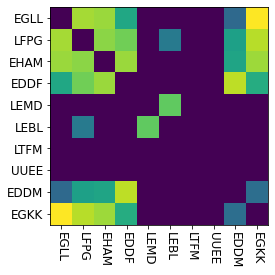

In [83]:
plt.imshow(adjacency_matrix)
plt.xticks(range(len(airports)), airports, fontsize=12, rotation=-90)
plt.yticks(range(len(airports)), airports, fontsize=12, rotation=0)
plt.show()
# print(len(graph.edges[0]))
# print(graph.edges)

## Graph Convolution Layer

In [84]:

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


## LSTM including graph convolution layer

In [85]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.denseinpu = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        print(f"The GCN output shape  = {gcn_out}")
        lstm_out = self.lstm(gcn_out)  # lstm_out has shape: (batch_size * num_nodes, lstm_units)
        print(f"The LSTM output shape  = {lstm_out}")
        dense_output = self.dense(
            lstm_out
        )
        print(f"The Dense has output shape {dense_output}")  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return #dense_output
        tf.transpose(
            output, [1, 2, 0])  
        # # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


## Training the model

In [92]:
in_feat = 9
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.summary()
model.fit(
    test_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

The GCN output shape  = Tensor("lstmgc_9/Reshape:0", shape=(None, 12, 20), dtype=float32)
The LSTM output shape  = Tensor("lstmgc_9/lstm_9/strided_slice_3:0", shape=(None, 64), dtype=float32)
The Dense has output shape Tensor("lstmgc_9/dense_9/BiasAdd:0", shape=(None, 3), dtype=float32)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 12, 10, 9)]       0         
                                                                 
 lstmgc_9 (LSTMGC)           multiple                  22045     
                                                                 
Total params: 22,045
Trainable params: 22,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
The GCN output shape  = Tensor("model_7/lstmgc_9/Reshape:0", shape=(None, 12, 20), dtype=float32)
The LSTM output shape  = Tensor("model_7/lstmgc_9/lstm

AttributeError: in user code:

    File "c:\Users\bcsli\Documents\TU Delft\Third Year\Project\spektral-environment\with_spektral\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\bcsli\Documents\TU Delft\Third Year\Project\spektral-environment\with_spektral\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\bcsli\Documents\TU Delft\Third Year\Project\spektral-environment\with_spektral\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\bcsli\Documents\TU Delft\Third Year\Project\spektral-environment\with_spektral\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "c:\Users\bcsli\Documents\TU Delft\Third Year\Project\spektral-environment\with_spektral\lib\site-packages\keras\engine\compile_utils.py", line 199, in __call__
        y_t, y_p, sw = match_dtype_and_rank(y_t, y_p, sw)
    File "c:\Users\bcsli\Documents\TU Delft\Third Year\Project\spektral-environment\with_spektral\lib\site-packages\keras\engine\compile_utils.py", line 685, in match_dtype_and_rank
        if ((y_t.dtype.is_floating and y_p.dtype.is_floating) or

    AttributeError: 'NoneType' object has no attribute 'dtype'
